In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
processed_dir = Path("../data/processed")
in_path = processed_dir / "windows_identity_df.csv"

assert in_path.exists(), f"Missing file: {in_path.resolve()}"

df = pd.read_csv(in_path)
print("Loaded dataset:", df.shape)
df.head()


Loaded dataset: (78914, 18)


,max,mean,std,range,energy,label,subject_id,age_group,activity_code,age,height_cm,weight_kg,gender,pid,synthetic_name,synthetic_address,synthetic_phone,synthetic_patient_id
0,1.505301,1.021371,0.161249,0.748475,213.839935,0,SA01,SA,D01,26,165,53.0,F,8b39978f3bf493e0,Allison Hill,"893 Nathaniel Estates Apt. 957, North Sarahpor...",631-335-1823x374,Xx-02681177
1,1.686817,1.094025,0.183646,0.891159,246.123306,0,SA01,SA,D01,26,165,53.0,F,8b39978f3bf493e0,Allison Hill,"893 Nathaniel Estates Apt. 957, North Sarahpor...",631-335-1823x374,Xx-02681177
2,1.598864,1.042618,0.176089,0.814388,223.612030,0,SA01,SA,D01,26,165,53.0,F,8b39978f3bf493e0,Allison Hill,"893 Nathaniel Estates Apt. 957, North Sarahpor...",631-335-1823x374,Xx-02681177
3,1.388703,1.040773,0.144043,0.621426,220.791382,0,SA01,SA,D01,26,165,53.0,F,8b39978f3bf493e0,Allison Hill,"893 Nathaniel Estates Apt. 957, North Sarahpor...",631-335-1823x374,Xx-02681177
4,1.441374,1.059405,0.145564,0.639070,228.705505,0,SA01,SA,D01,26,165,53.0,F,8b39978f3bf493e0,Allison Hill,"893 Nathaniel Estates Apt. 957, North Sarahpor...",631-335-1823x374,Xx-02681177


In [3]:
FEATURE_COLS = ["max", "mean", "std", "range", "energy"]

X = df[FEATURE_COLS]
y = df["label"]
groups = df["subject_id"]  # split por sujeito

print("X:", X.shape)
print("y distribution:", y.value_counts().to_dict())
print("Subjects:", groups.nunique())


X: (78914, 5)
y distribution: {0: 52066, 1: 26848}
Subjects: 38


In [4]:
gss = GroupShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42
)

train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Train subjects:", groups.iloc[train_idx].nunique())
print("Test subjects:", groups.iloc[test_idx].nunique())

Train size: (65242, 5)
Test size: (13672, 5)
Train subjects: 30
Test subjects: 8


In [5]:
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

In [6]:
t0 = time.perf_counter()
logreg_pipeline.fit(X_train, y_train)
train_time_lr = time.perf_counter() - t0

In [7]:
t0 = time.perf_counter()
y_pred_lr = logreg_pipeline.predict(X_test)
test_time_lr = time.perf_counter() - t0

In [8]:
print("=== Logistic Regression ===")
print("Train time (s):", round(train_time_lr, 4))
print("Test time (s):", round(test_time_lr, 4))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, target_names=["ADL","Fall"]))
cm_lg = confusion_matrix(y_test, y_pred_lr)


=== Logistic Regression ===
Train time (s): 0.1509
Test time (s): 0.002
Balanced accuracy: 0.6143249774178946
              precision    recall  f1-score   support

         ADL       0.87      0.43      0.57     10313
        Fall       0.31      0.80      0.45      3359

    accuracy                           0.52     13672
   macro avg       0.59      0.61      0.51     13672
weighted avg       0.73      0.52      0.54     13672



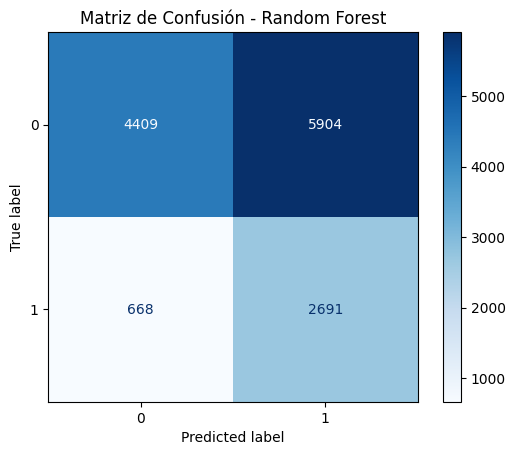

In [9]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lg)
disp.plot(cmap="Blues")

plt.title("Matriz de Confusión - Random Forest")
plt.show()

In [10]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

In [11]:
t0 = time.perf_counter()
rf.fit(X_train, y_train)
train_time_rf = time.perf_counter() - t0

In [12]:
t0 = time.perf_counter()
y_pred_rf = rf.predict(X_test)
test_time_rf = time.perf_counter() - t0

In [13]:
print("=== Random Forest ===")
print("Train time (s):", round(train_time_rf, 4))
print("Test time (s):", round(test_time_rf, 4))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=["ADL","Fall"]))
cm_rf = confusion_matrix(y_test, y_pred_rf)

=== Random Forest ===
Train time (s): 8.8155
Test time (s): 0.164
Balanced accuracy: 0.6208411896678327
              precision    recall  f1-score   support

         ADL       0.81      0.82      0.81     10313
        Fall       0.43      0.43      0.43      3359

    accuracy                           0.72     13672
   macro avg       0.62      0.62      0.62     13672
weighted avg       0.72      0.72      0.72     13672



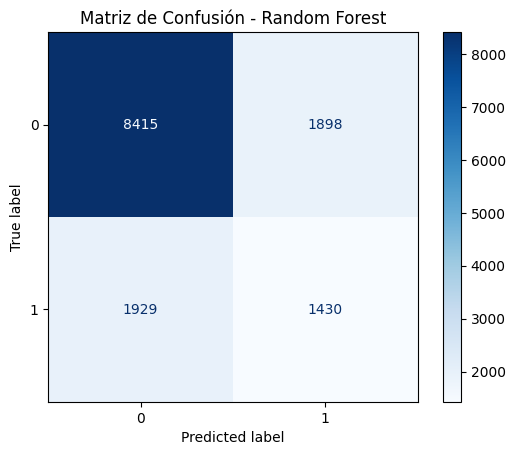

In [14]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot(cmap="Blues")

plt.title("Matriz de Confusión - Random Forest")
plt.show()

In [16]:
summary = pd.DataFrame([
    {
        "model": "Logistic Regression",
        "train_time_s": train_time_lr,
        "test_time_s": test_time_lr,
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_lr),
    },
    {
        "model": "Random Forest",
        "train_time_s": train_time_rf,
        "test_time_s": test_time_rf,
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_rf),
    }
])

summary


,model,train_time_s,test_time_s,balanced_accuracy
0,Logistic Regression,0.150920,0.002035,0.614325
1,Random Forest,8.815527,0.164018,0.620841
